In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from ranges.stripe_range import StripeRange
from hierarchical.kdtree import *
from baselines.baselines import linear_search
from hierarchical.index import HierarchicalIndex

In [2]:
def round_to_nearest_power_fraction(arr):
    """
    Round each element in arr to the nearest 1 / (2^i) for i = 1, 2, ..., such that 1/(2^i) < 1.
    Assumes all elements in arr are in (0,1).
    """
    powers = np.array([1 / (2 ** i) for i in range(1, 20)])  # Adjust range if needed
    arr = np.asarray(arr)

    def nearest_fraction(x):
        diffs = np.abs(powers - x)
        return powers[np.argmin(diffs)]

    return np.vectorize(nearest_fraction)(arr)

In [ ]:
points = np.random.zipf(1.5, size=(20, 2))
tree = KDTree(points)
query = StripeRange.sample_stripe(points, r=1/4, tolerance=0.001)

Found!


In [4]:
points[linear_search(points, query)]

array([[    3,    18],
       [    1,    92],
       [    1, 18671],
       [    9, 54940],
       [    8,    12]])

In [5]:
res = np.array(tree.query(query))
res[linear_search(res, query)]

array([[    8,    12],
       [    9, 54940],
       [    3,    18],
       [    1,    92],
       [    1, 18671]])

In [6]:
n = 10000
# dim = [2, 4, 8, 16, 32]
dim = [2]

results = {
    "hie_time": [],
    "linear_time": [],
    "kd_time": [],
    "hie_recall": [],
    "kd_recall": [],
    "dim": [],
    "n_points": [],
    "width": [],
}

for d in dim:
    print(f"dim: {d} : {dim}")
    points = np.random.zipf(1.5, size=(n, d))

    print("Building index...")
    index = HierarchicalIndex(points, decay=4)
    index.build_index()
    index.find_coverage()
    index.find_neighbor_stats()
    kdtree = KDTree(points)

    # Query range
    for width in [
        1 / 2,
        1 / 4,
        1 / 8,
        1 / 16,
        1 / 32,
        1 / 64,
        1 / 128,
        1 / 256,
        1 / 512,
    ]:
        for i in range(5):
            print(f"\t sample {i+1} out of {5}")
            query = StripeRange.sample_stripe(points, r=width, tolerance=0.001)

            print("Querying...")
            start = time.time()
            linear_results = linear_search(points, query)
            linear_time = time.time() - start

            start = time.time()
            hie_results = index.query(query)
            hie_time = time.time() - start
            hie_recall = (
                len(hie_results) / len(linear_results)
                if len(linear_results) > 0
                else 1.0
            )

            start = time.time()
            # kd_results = kdtree.query(query)
            kd_results = np.array(kdtree.query(query))
            # kd_results = kd_results[linear_search(kd_results, query)]
            kd_time = time.time() - start
            kd_recall = (
                len(kd_results) / len(linear_results)
                if len(linear_results) > 0
                else 1.0
            )

            results["hie_time"].append(hie_time)
            results["linear_time"].append(linear_time)
            results["kd_time"].append(kd_time)
            results["hie_recall"].append(hie_recall)
            results["kd_recall"].append(kd_recall)
            results["dim"].append(d)
            results["n_points"].append(n)
            results["width"].append(len(linear_results))

dim: 2 : [2]
Building index...
L: 7


/home/mohsen/venv/lib/python3.12/site-packages/miniball.py:46: RuntimeWarning: invalid value encountered in divide
  U /= B[:, None]


	 sample 1 out of 5
Found!
Querying...
candidates:  5091 all:  10000
	 sample 2 out of 5
Found!
Querying...
candidates:  5087 all:  10000
	 sample 3 out of 5
Found!
Querying...
candidates:  5388 all:  10000
	 sample 4 out of 5
Found!
Querying...
candidates:  5058 all:  10000
	 sample 5 out of 5
Found!
Querying...
candidates:  5066 all:  10000
	 sample 1 out of 5
Found!
Querying...
candidates:  2602 all:  10000
	 sample 2 out of 5
Found!
Querying...
candidates:  2518 all:  10000
	 sample 3 out of 5
Found!
Querying...
candidates:  2560 all:  10000
	 sample 4 out of 5
Found!
Querying...
candidates:  2521 all:  10000
	 sample 5 out of 5
Found!
Querying...
candidates:  2616 all:  10000
	 sample 1 out of 5
Found!
Querying...
candidates:  1302 all:  10000
	 sample 2 out of 5
Found!
Querying...
candidates:  1286 all:  10000
	 sample 3 out of 5
Found!
Querying...
candidates:  1275 all:  10000
	 sample 4 out of 5
Found!
Querying...
candidates:  1309 all:  10000
	 sample 5 out of 5
Found!
Queryin

In [7]:
df = pd.DataFrame(results)
df.head()

,hie_time,linear_time,kd_time,hie_recall,kd_recall,dim,n_points,width
0,0.006629,0.006621,0.010837,1.0,1.0,2,10000,5000
1,0.006118,0.006706,0.009602,1.0,1.0,2,10000,5008
2,0.006182,0.006917,0.008363,1.0,1.0,2,10000,5009
3,0.005580,0.006725,0.010246,1.0,1.0,2,10000,5001
4,0.005548,0.006608,0.009594,1.0,1.0,2,10000,5008


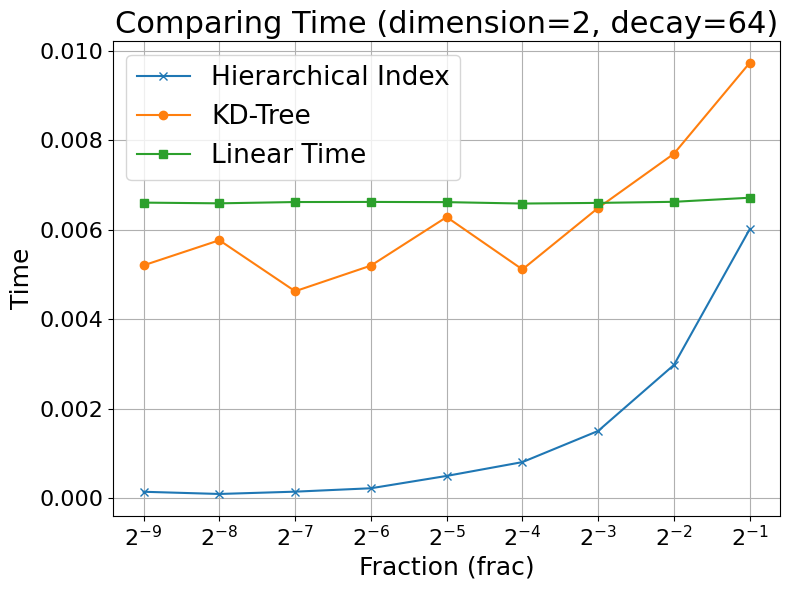

In [8]:
# d = 2
# df = results[results["dim"] == d]
df["frac"] = round_to_nearest_power_fraction(df["width"] / df["n_points"])

# Group by frac and compute mean times
grouped = df.groupby('frac').mean(numeric_only=True)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(grouped.index, grouped['hie_time'], marker='x', label='Hierarchical Index')
plt.plot(grouped.index, grouped['kd_time'], marker='o', label='KD-Tree')
plt.plot(grouped.index, grouped['linear_time'], marker='s', label='Linear Time')

# Formatting
plt.xlabel('Fraction (frac)', fontsize=18)
plt.ylabel('Time', fontsize=18)
plt.title(f'Comparing Time (dimension={d}, decay=64)', fontsize=22)
plt.legend(fontsize=19)
plt.grid(True)
plt.xscale('log', base=2)
plt.xticks(fontsize=16)  # You can adjust the number as needed
plt.yticks(fontsize=16)
plt.tight_layout()
# plt.savefig(f'zipf_with_width_dim_{d}_decay=8.png')
plt.show()